# Prediccion del resultado de eventos musicales


Se cuenta con un conjunto de 360 eventos realizados el mes de abril en Estados Unidos. Para cada uno de estos eventos se cuenta con el resultado de éstos, a través del número de tickets y el porcentaje de ocupación del lugar del evento. Es este indicador, el porcentaje, el valor que constituirá la variable dependiente del problema.

Para analizar el problema, se buscó contar con un conjunto de variables independientes, que permitieran caracterizar al evento. En primer lugar, se tomaron datos del evento:
    * estado de EEUU
    * día de la semana
    * capacidad del recinto
    * precio del ticket

Por otro lado, se realizó la recopilación de datos de redes sociales, accediendo a las APIs de las redes, para cada uno de los artistas del conjunto. Se comenzó con la recopilación de las redes (los nombres) para cada artista. Posteriormente, se hizo la captura de datos, de manera automática.

Las redes accedidas fueron:
    * Facebook : likes en la pagina del artista
    * Youtube : suscriptores del canal
    * Instagram : followers, likes
    * Spotify : followers, popularidad
    * Twitter : followers, menciones en USA, menciones mundo

Además, se realizó la captura en días distintos (una semana de diferencia), obteniendo un indicador de crecimiento para algunas de las cifras. Estas son:
    * crecimiento likes de facebook
    * crecimiento followers de instagram
    * crecimiento followers de twitter

El resultado de esto fue la construcción de un vector de 15 componentes, con los datos de las redes sociales (variables independientes) junto a los datos de los eventos.

Este notebook esta organizado de la siguiente manera:
    * carga de datos
    * pruebas con todas las variables
        - asignacion de variables (1)
        - analisis de variables
        - modelo de regresion, con validacion cruzada
    * recursive feature elimination
    * pruebas con algunas variables
        - asignacion de variables (2)
        - prueba de algoritmos, con conjunto de test
        - modelo de regresion, con validacion cruzada

In [2267]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn_pandas as sp
import sys
import copy
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings('ignore')

threshold = 77
algorithm = 'randomforest'

In [2143]:
# modelos de regresion

models = {}
models['linearreg']    = LinearRegression()
models['svr']          = SVR(kernel='rbf', C=1.0, gamma='auto', degree=2)
models['knn']          = KNeighborsRegressor()
models['ridge']        = Ridge(alpha=[0.001])
models['lasso']        = Lasso()
models['elasticnet']   = ElasticNet()
models['dectree']      = DecisionTreeRegressor(max_features=0.1, criterion='friedman_mse', random_state=3)
models['randomforest'] = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor()
models['knn']          = KNeighborsRegressor()
models['MLPRegressor'] = MLPRegressor()

# Pruebas con todas las variables

En primer lugar se realiza la carga de datos, separando los conjuntos de entrenamiento y test, y extrayendo la variable dependiente (values). Se determinó utilizar una separación del conjunto de datos, destinando un 10% de la muestra para test, y el 90% restante para entrenamiento.


In [2443]:
# carga de datos

dataset = pd.read_csv('/home/dgomez/rrss_new2_uniq.csv')
print "count: " + str(dataset['tickets'].count())
print "mean: " + str(dataset['tickets'].mean())
print "std: " + str(dataset['tickets'].std())
dataset = dataset.replace(np.NaN, 0)
total = len(dataset)
size = int(0.90 * total)

count: 410
mean: 79.23658536585366
std: 24.2548637130708


In [2465]:
# seleccion de variables

mapper = sp.DataFrameMapper([
    ('dayofweek', LabelBinarizer()),
    (['state_pob', 'capacity', 'price', 'facebook_likes', 'youtube_suscrs',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
     'facebook_crec', 'instagram_crec', 'twitter_crec'], StandardScaler())
    ])
X = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'instagram_crec', 'twitter_crec']]
Xy = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'instagram_crec', 'twitter_crec', 'tickets']]
X = mapper.fit_transform(X) # numpy.ndarray
y = dataset['tickets'] # dataframe

## Analisis de variables

A continuación se realiza el análisis de las variables, graficando la relación entre cada par de variables. También, se grafica la relación de cada variable con la variable dependiente ("tickets").
<BR>
Este análisis permite revisar el nivel de correlación de cada variable respecto al valor a predecir.

In [2286]:
Xy[0:10]

,state_pob,dayofweek,capacity,price,facebook_likes,youtube_suscrs,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,instagram_crec,twitter_crec,tickets
0,6547629,6,953,29.5,10257354,289662812,7300000,535000,3136225,85,12660288,467,1000,0.0,0.0,0.0,100
1,6483802,2,1417,52.5,772087,116092592,126400,44481,170318,60,91801,32,39,0.0,0.0,0.0,98
2,3831074,3,1270,28.0,456660,21710193,221400,14716,96381,61,141023,64,92,0.0,0.0,0.0,55
3,4533372,4,1300,17.5,456660,21710193,221400,14716,96381,61,141023,64,92,0.0,0.0,0.0,40
4,38332521,5,10000,37.5,456660,21710193,221400,14716,96381,61,141023,64,92,0.0,0.0,0.0,100
5,38332521,5,600,12.5,456660,21710193,221400,14716,96381,61,141023,64,92,0.0,0.0,0.0,100
6,6724540,2,500,40.0,456660,21710193,221400,14716,96381,61,141023,64,92,0.0,0.0,0.0,97
7,38332521,4,1000,10.0,456660,21710193,221400,14716,96381,61,141023,64,92,0.0,0.0,0.0,67
8,5303925,3,318,14.5,51415,13723,1402,446,11804,18,4089,14,22,0.0,0.0,0.0,48
9,5029196,4,625,19.0,79574,115491,50100,6412,26776,53,44974,32,35,0.0,0.0,0.0,89


In [2287]:
Xy.describe().round(decimals=2)

,state_pob,dayofweek,capacity,price,facebook_likes,youtube_suscrs,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,instagram_crec,twitter_crec,tickets
count,715.00,715.00,715.00,715.00,715.00,7.150000e+02,715.00,715.00,715.00,715.00,715.00,715.00,715.00,715.0,715.0,715.0,715.00
mean,12557991.35,3.44,3422.31,51.85,3952611.36,5.137276e+07,2830737.85,233246.40,931004.71,56.70,3722486.11,249.50,298.09,0.0,0.0,0.0,83.55
std,10231743.75,1.71,5856.39,44.80,9275800.97,1.588262e+08,10459358.44,682865.57,1952863.72,19.31,12346671.39,365.07,388.61,0.0,0.0,0.0,22.39
min,601723.00,0.00,100.00,6.00,1669.00,0.000000e+00,257.00,0.00,2.00,0.00,41.00,0.00,0.00,0.0,0.0,0.0,5.00
25%,5303925.00,2.00,513.00,21.50,66464.00,1.673415e+05,19100.00,2761.00,28315.00,46.00,13818.50,15.00,19.00,0.0,0.0,0.0,68.00
50%,8791894.00,4.00,1354.00,39.00,305992.00,2.814914e+06,92100.00,11188.00,104691.00,59.00,72263.00,64.00,92.00,0.0,0.0,0.0,99.00
75%,18801310.00,5.00,2992.00,64.12,2032316.00,2.213677e+07,435500.00,52447.50,694252.50,70.00,492895.00,221.00,335.00,0.0,0.0,0.0,100.00
max,38332521.00,6.00,55292.00,478.50,44677187.00,1.664666e+09,76100000.00,4090900.00,10144141.00,96.00,66058593.00,1000.00,1000.00,0.0,0.0,0.0,100.00


In [2292]:
colnames = dataset.drop(columns=['name']).columns
rows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
cols = [0,1,2,3]*4
#f, axes = plt.subplots(4, 4, figsize=(20, 16), sharex=False)
#for colname,i,j in list(zip(colnames,rows,cols)):
#    sns.distplot(dataset.dropna()[colname], ax=axes[i, j])

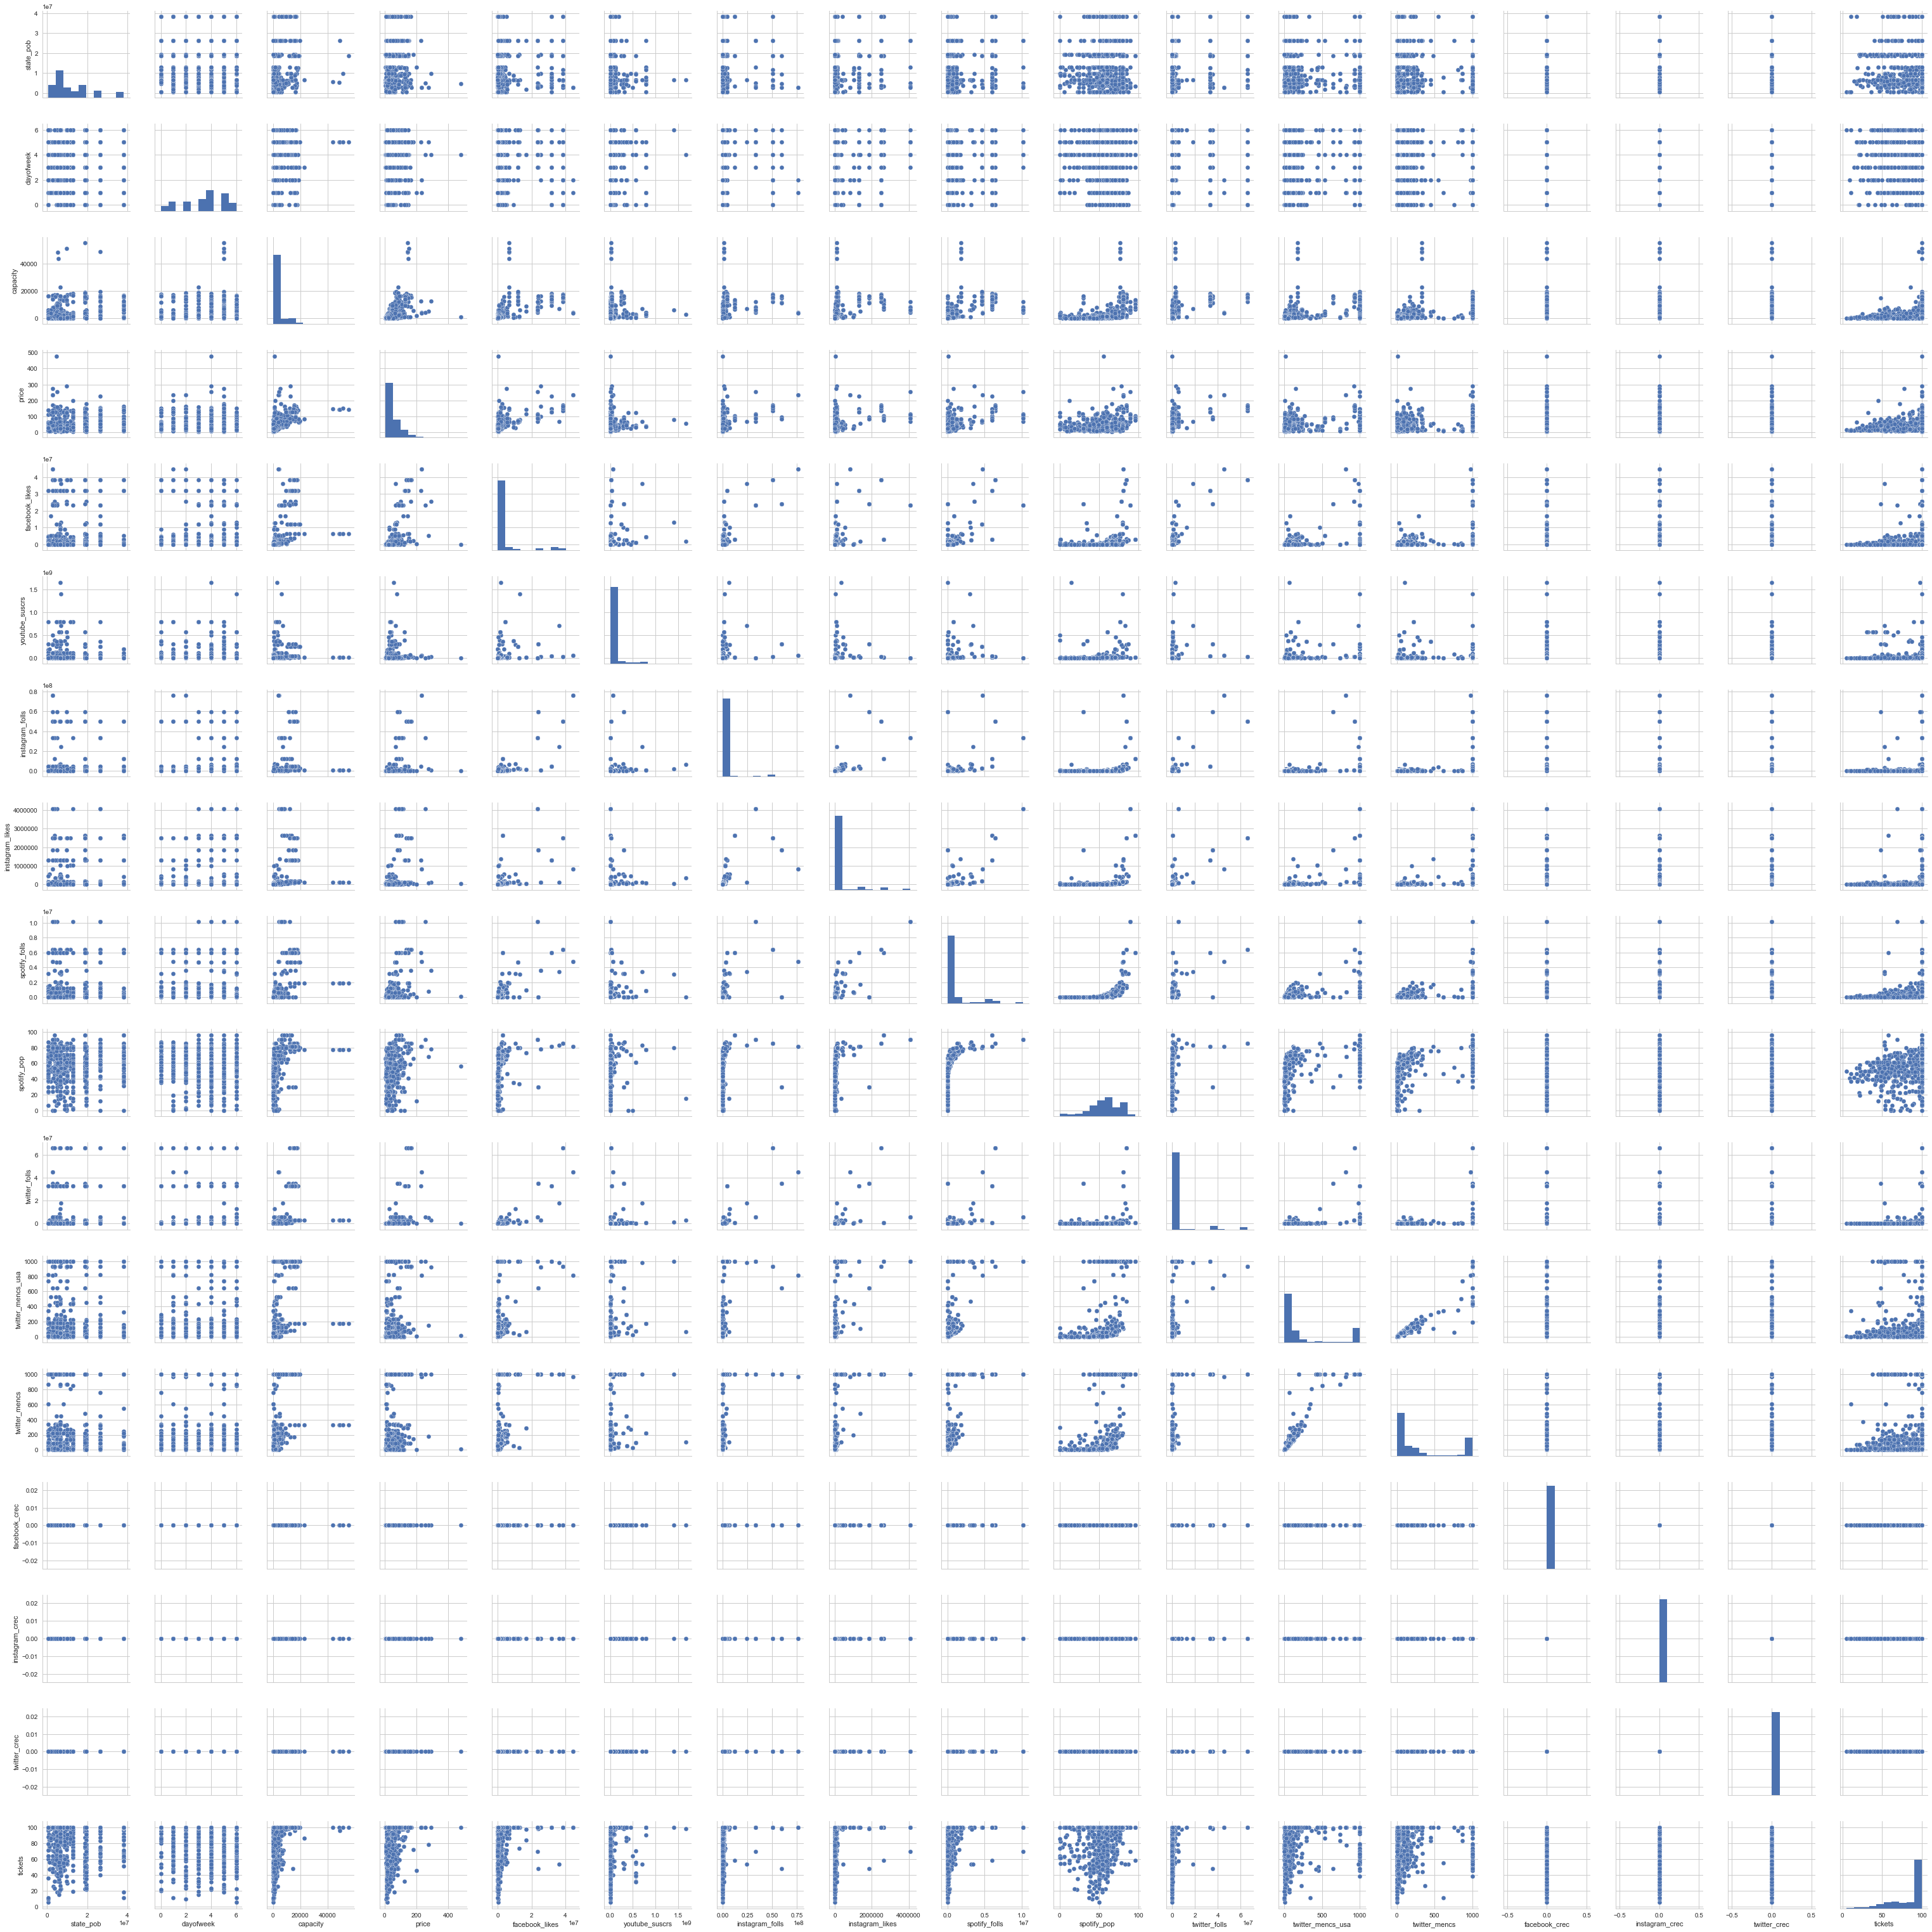

In [2289]:
# grafico de dispersion entre variables

data_df = pd.DataFrame(Xy, columns=['state_pob', 'dayofweek', 'capacity', 'price', 'facebook_likes','youtube_suscrs','instagram_folls','instagram_likes','spotify_folls','spotify_pop','twitter_folls','twitter_mencs_usa','twitter_mencs', 'facebook_crec', 'instagram_crec', 'twitter_crec', 'tickets'])
sns.set(style='whitegrid', context='notebook')
features_plot = data_df.columns
data_df[0:10]
sns.pairplot(data_df)#, kind='reg')#, size=2.0);
plt.tight_layout()

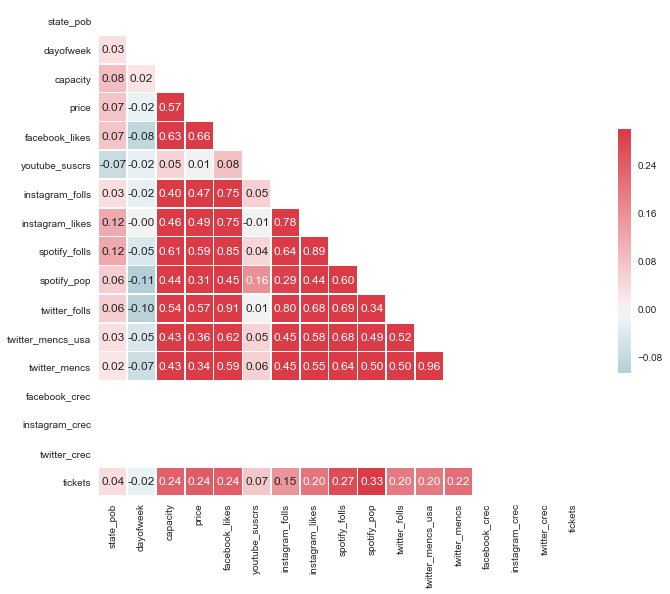

In [2290]:
# correlacion entre variables

corr_vectors = Xy.corr()
mask = np.zeros_like(corr_vectors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_vectors, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

En base a la observacion de las variables, se puede apreciar que hay variables que estan poco correlacionadas con la venta de tickets. En particular, esto sucede con: <i>state_pob, dayofweek, twitter_mencs_usa, twitter_mencs, facebook_crec, instagram_crec</i> y <i>twitter_crec</i>, con una correlacion inferior al 10%.

## Modelo de regresion

A continuación se realiza el entrenamiento del modelo. Luego de probar con diversos algoritmos, se decidió utilizar <I>RandomForestRegressor</I>.

Para medir la efectividad del proceso, se implementó una medida del resultado considerando una categorización en clases de los datos y la prediccion, considerando un umbral para el valor de la variable dependiente. En este caso, se determinó que los valores mayores o iguales a 77% serían considerados un <b>resultado positivo</b>, y valores menores, un <b>resultado negativo</b>.

De esta manera, el sistema realiza el conteo de casos satisfactoriamente predichos, entregando un score de <B><I>accuracy</I></B>. Tambien se calculan los valores de R^2 (coeficiente de determinacion) y RMSE (raiz del error cuadratico medio).

In [ ]:
# implementacion modelo, utilizando validacion cruzada

model = models[algorithm]

X=np.array(X)
predictions = []
r2s = []
rmses = []

all_aciertos_positivo = 0; all_aciertos_negativo = 0
all_errores_positivo = 0; all_errores_negativo = 0

kf = KFold(n_splits=10,shuffle=True)
for k, (train, test) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train,:], X[test,:]
    y_train, y_test = y[train], y[test]
    model = models['randomforest']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = y_pred.copy()
    
    measures.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    y_list = list(y_test)
    for k in range(0, len(predictions)):
        #print str(y_list[k]) + ' :',
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
            
        if y_list[k] >= threshold: sum_positivo += 1
        else: sum_negativo += 1
        if predictions[k] >= threshold: sum_predict_positivo += 1
        else: sum_predict_negativo += 1

    all_aciertos_positivo += aciertos_positivo
    all_aciertos_negativo += aciertos_negativo
    all_errores_positivo  += errores_positivo
    all_errores_negativo  += errores_negativo

    r2s.append(r2_score(y_list, predictions))
    rmses.append(np.sqrt(mean_squared_error(predictions, y_list)))
    
    print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
    print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
    print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    df = pd.DataFrame({'real': y_list, 'prediction': predictions})    

print
print "R2s: ", np.mean(r2s)
print "RMSEs: ",np.mean(rmses)
print "scores: ", np.mean(scores)

print
conf = pd.DataFrame([[all_aciertos_positivo, all_errores_positivo], [all_errores_negativo, all_aciertos_negativo]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.12, RMSE: 23.15, SCORE: 28 / 41 = 0.683
R2: -0.04, RMSE: 29.31, SCORE: 27 / 41 = 0.659
R2: 0.08, RMSE: 22.38, SCORE: 28 / 41 = 0.683
R2: 0.22, RMSE: 24.75, SCORE: 28 / 41 = 0.683


Respecto a la predicción, se grafica su resultado, donde se muestran los valores reales versus las predicciones. En este gráfico se puede apreciar que el cuadrante superior-derecha muestra los casos positivos correctamente clasificados, lo mismo con el cuadrante inferior-izquierda, para los casos negativos. El resto de los casos son los erroneamente clasificados.

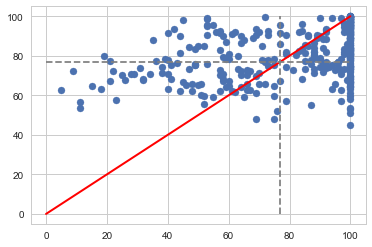

In [1725]:
# grafico de dispersion de las predicciones

plt.scatter(y_list_all, predictions_all)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

## Recursive Feature Elimination

A continuacion, se prueba la eliminacion recursiva de caracteristicas, para construir un modelo con menos variables.

In [2466]:
# inicializacion y ejecucion del modelo

from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
Xdf = pd.DataFrame(X)
print list(Xdf.columns.values)[:62]
print rfe.support_
y_pred = rfe.predict(X_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[False False False False False False False  True  True  True  True  True
  True  True  True  True  True False False False False False]


In [2460]:
# calculo de errores y aciertos

sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
errores_positivo = 0; errores_negativo = 0
sum_positivo = 0; sum_negativo = 0
sum_predict_positivo = 0; sum_predict_negativo = 0
total_test = len(X_test)

y_list = list(y_test)
for k in range(0, len(y_pred)):
    sum += abs(y_pred[k] - y_list[k])
    if y_list[k] >= threshold and y_pred[k] >= threshold:
        aciertos_positivo += 1
    if y_list[k] >= threshold and y_pred[k] < threshold:
        errores_positivo += 1
    if y_list[k] < threshold and y_pred[k] < threshold:
        aciertos_negativo += 1
    if y_list[k] < threshold and y_pred[k] >= threshold:
        errores_negativo += 1
    if y_list[k] >= threshold:
        sum_positivo += 1
    else:
        sum_negativo += 1
    if y_pred[k] >= threshold:
        sum_predict_positivo += 1
    else:
        sum_predict_negativo += 1

In [2464]:
# estadisticas del modelo

print
print "R2: " + str(round(r2_score(y_test, y_pred), 2))
print "RMSE: " + str(round(np.sqrt(mean_squared_error(y_pred, y_test)), 2))
print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
print "PRECISION: " + str(round(1.0 * aciertos_positivo / sum_predict_positivo, 3))
print "RECALL: " + str(round(1.0 * aciertos_positivo / sum_positivo, 3))
df = pd.DataFrame({'real': y_test, 'prediction': y_pred})
print "correlacion: " + str(round(df.corr()['real'][0], 2))
print "confusion-matrix:"
conf = pd.DataFrame([[errores_positivo, aciertos_positivo], [aciertos_negativo, errores_negativo]], columns=['negativo', 'positivo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.13
RMSE: 23.37
SCORE: 56 / 82 = 0.683
PRECISION: 0.686
RECALL: 0.778
correlacion: 0.39
confusion-matrix:


,negativo,positivo
positivo,10,35
negativo,21,16


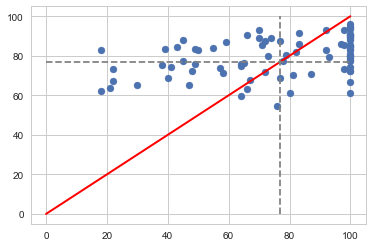

In [2462]:
# grafico de dispersion de las predicciones

plt.scatter(y_test, y_pred)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

# Pruebas con algunas variables

En base al analisis de variables realizado, ahora se eliminan algunas variables, generando un dataset mas reducido.
Tambien se prueban algunos metodos de normalizacion para las variables.

In [2467]:
# nuevo armado del conjunto de variables

mapper = sp.DataFrameMapper([
    #('dayofweek', LabelBinarizer()),
    ([
    'state_pob', 
    'capacity',
    'price', 
    'facebook_likes', 'youtube_suscrs', 
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls',
    #'twitter_mencs', 'twitter_mencs_usa'
    #,'facebook_crec', 'instagram_crec', 'twitter_crec'
    ], StandardScaler())
    #], Normalizer())
    #], MinMaxScaler())
    #], RobustScaler())
    ])
X = dataset[[
    #'dayofweek',
    'state_pob', 
    'capacity',
    'price',
    'facebook_likes', 'youtube_suscrs', 
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls',
    #'twitter_mencs', 'twitter_mencs_usa'
    #,'facebook_crec', 'instagram_crec', 'twitter_crec'
    ]]
X = mapper.fit_transform(X)
y = dataset['tickets']

## Pruebas de algoritmos, con conjunto de test

Se separa el dataset en dos conjuntos: training y test, y se prueban diferentes algoritmos de regresion.


knn:
	R2: 0.06
	RMSE: 24.55
	SCORE: 53 / 82 = 0.646
   negativo  positivo
0        15        39
1        14        14


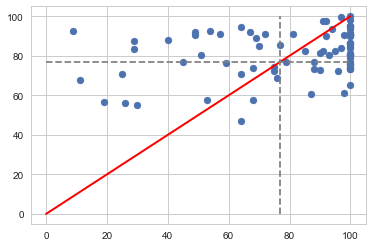

gradient:
	R2: 0.18
	RMSE: 22.92
	SCORE: 58 / 82 = 0.707
   negativo  positivo
0        13        42
1        16        11


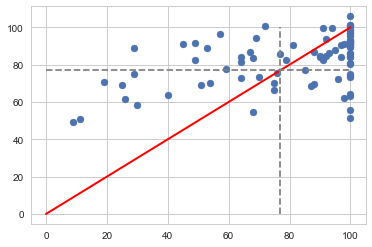

randomforest:
	R2: 0.18
	RMSE: 22.92
	SCORE: 59 / 82 = 0.72
   negativo  positivo
0        13        43
1        16        10


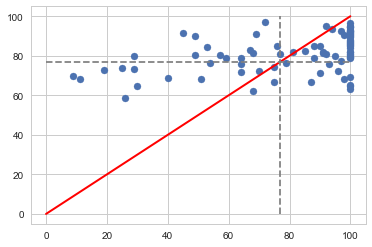

adaboost:
	R2: 0.14
	RMSE: 23.53
	SCORE: 49 / 82 = 0.598
   negativo  positivo
0         7        27
1        22        26


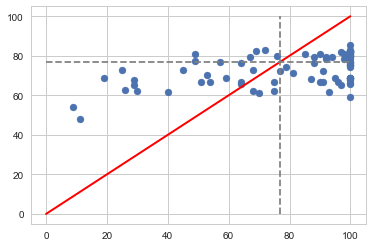

MLPRegressor:
	R2: 0.04
	RMSE: 24.82
	SCORE: 44 / 82 = 0.537
   negativo  positivo
0         4        19
1        25        34


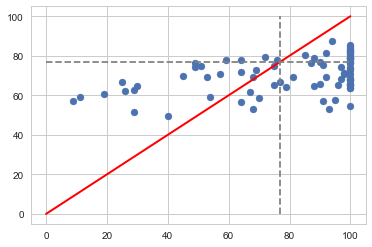

In [2455]:
# probando diferentes algoritmos de regresion

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

models = {}
models['knn']          = KNeighborsRegressor()
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor(loss='huber', criterion='mse')
models['randomforest'] = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)
models['MLPRegressor'] = MLPRegressor(activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=900)
                 
for alg in models:
    print alg + ':'
    model = models[alg]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    #total_test = len(X)
    y_list = list(y_test)

    for k in range(0, len(predictions)):
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
        if y_list[k] >= threshold:
            sum_positivo += 1
        else:
            sum_negativo += 1
        if predictions[k] >= threshold:
            sum_predict_positivo += 1
        else:
            sum_predict_negativo += 1

    print "\tR2: " + str(round(r2_score(y_list, predictions), 2))
    print "\tRMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2))
    print "\tSCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    conf = pd.DataFrame([[errores_negativo, aciertos_positivo], [aciertos_negativo, errores_positivo]], columns=['negativo', 'positivo'])
    conf.rename(index={0:'negativo', 1:'positivo'})
    print conf
    
    # grafico de dispersion de las predicciones
    plt.scatter(y_list, predictions)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    #x0 = [0, 0, 30, 30]
    #y0 = [0, threshold, threshold, 0]
    #ax.fill(x0, y0, alpha=0.2)
    plt.show()

Del analisis realizado, se observa que los mejores resultados se obtienen con RandomForest. MLP y Adaboost tambien generan resultados interesantes.

## Modelo de regresion, con validacion cruzada

Ahora se realiza la validacion utilizando validacion cruzada, con 10 folds. La ejecucion se repite 3 veces, y se promedian sus resultados. En esta ejecucion se prueba con RandomForest, sin embargo, en el codigo tambien se encuentra definido el modelo para MLP y AdaBoost (comentado).

R2: 0.06, RMSE: 24.95, SCORE: 22 / 41 = 0.537
R2: 0.06, RMSE: 24.3, SCORE: 27 / 41 = 0.659
R2: -0.11, RMSE: 24.42, SCORE: 22 / 41 = 0.537
R2: -0.18, RMSE: 28.24, SCORE: 26 / 41 = 0.634
R2: 0.29, RMSE: 18.04, SCORE: 32 / 41 = 0.78
R2: 0.19, RMSE: 26.96, SCORE: 30 / 41 = 0.732
R2: 0.18, RMSE: 21.12, SCORE: 26 / 41 = 0.634
R2: 0.35, RMSE: 19.0, SCORE: 29 / 41 = 0.707
R2: 0.14, RMSE: 19.56, SCORE: 27 / 41 = 0.659
R2: -0.72, RMSE: 24.88, SCORE: 22 / 41 = 0.537

R2s:  0.02776442585291463
RMSEs:  23.145266643924078
scores:  0.6416
coef.corr:  0.2905623215197191
   negativo  positivo
0        72       176
1        87        75



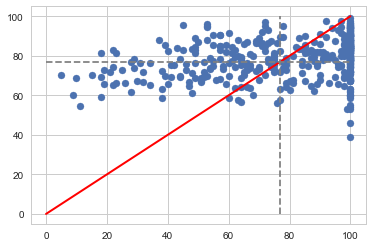

R2: 0.03, RMSE: 23.9, SCORE: 25 / 41 = 0.61
R2: -0.16, RMSE: 22.49, SCORE: 22 / 41 = 0.537
R2: -0.08, RMSE: 21.36, SCORE: 27 / 41 = 0.659
R2: -0.02, RMSE: 25.25, SCORE: 26 / 41 = 0.634
R2: 0.14, RMSE: 23.29, SCORE: 25 / 41 = 0.61
R2: 0.12, RMSE: 23.78, SCORE: 24 / 41 = 0.585
R2: 0.14, RMSE: 21.91, SCORE: 24 / 41 = 0.585
R2: 0.32, RMSE: 21.12, SCORE: 31 / 41 = 0.756
R2: 0.23, RMSE: 22.19, SCORE: 29 / 41 = 0.707
R2: 0.09, RMSE: 24.04, SCORE: 29 / 41 = 0.707

R2s:  0.08120088702293803
RMSEs:  22.93379369614119
scores:  0.639
coef.corr:  0.32951052790301005
   negativo  positivo
0        69       172
1        90        79



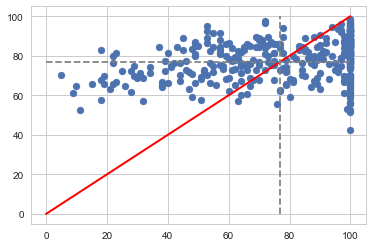

R2: 0.07, RMSE: 25.92, SCORE: 25 / 41 = 0.61
R2: -0.12, RMSE: 23.73, SCORE: 20 / 41 = 0.488
R2: 0.33, RMSE: 21.17, SCORE: 31 / 41 = 0.756
R2: 0.18, RMSE: 24.73, SCORE: 28 / 41 = 0.683
R2: -0.04, RMSE: 22.77, SCORE: 22 / 41 = 0.537
R2: 0.14, RMSE: 21.47, SCORE: 25 / 41 = 0.61
R2: 0.13, RMSE: 22.85, SCORE: 25 / 41 = 0.61
R2: -0.14, RMSE: 24.39, SCORE: 27 / 41 = 0.659
R2: -0.49, RMSE: 20.51, SCORE: 27 / 41 = 0.659
R2: 0.1, RMSE: 24.0, SCORE: 25 / 41 = 0.61

R2s:  0.015646727750988475
RMSEs:  23.154951604122104
scores:  0.6222000000000001
coef.corr:  0.30794674798617283
   negativo  positivo
0        75       171
1        84        80



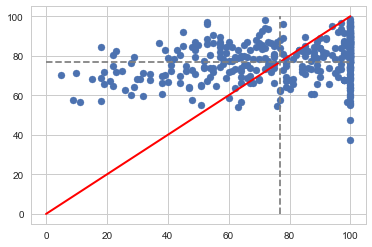

---------------------------------------------
RESUMEN:
r2: 0.04153734687561371
rsme: 23.078003981395792
score: 0.6342666666666666


,negativo,positivo
positivo,72.0,173.0
negativo,87.0,78.0


In [2456]:
# implementacion modelo, utilizando validacion cruzada... se ejecuta 3 veces, con 10 folds.

threshold = 77
all_r2 = []
all_rsme = []
all_score = []
all_aciertos_pos = []
all_aciertos_neg = []
all_errores_pos = []
all_errores_neg = []

for k in range(0, 3):
    r2s = []
    rmses =[]
    scores = []
    X=np.array(X)
    predictions_all = []
    aciertos_pos = []; aciertos_neg = []; errores_pos = []; errores_neg = []
    sum_ylist = 0; sum_pred = 0
    p = 0
    yy = []
    xx = []
    y_list_all = []
    X_list_all = []

    kf = KFold(n_splits=10, shuffle=True)
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        model = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, n_jobs=4)
        #model = MLPRegressor(activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=900)
        #model = AdaBoostRegressor(base_estimator=None)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions = y_pred.copy()

        sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
        errores_positivo = 0; errores_negativo = 0
        sum_positivo = 0; sum_negativo = 0
        sum_predict_positivo = 0; sum_predict_negativo = 0
        total_test = len(X_test)
        X_list = list(X_test)
        y_list = list(y_test)

        for k in range(0, len(predictions)):
            sum += abs(predictions[k] - y_list[k])
            if y_list[k] >= threshold and predictions[k] >= threshold:
                aciertos_positivo += 1
            if y_list[k] >= threshold and predictions[k] < threshold:
                errores_positivo += 1
            if y_list[k] < threshold and predictions[k] < threshold:
                aciertos_negativo += 1
            if y_list[k] < threshold and predictions[k] >= threshold:
                errores_negativo += 1
            if y_list[k] >= threshold:
                sum_positivo += 1
            else:
                sum_negativo += 1
            if predictions[k] >= threshold:
                sum_predict_positivo += 1
            else:
                sum_predict_negativo += 1

        print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
        print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
        print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
        df = pd.DataFrame({'real': y_list, 'prediction': predictions})

        aciertos_pos.append(aciertos_positivo)
        aciertos_neg.append(aciertos_negativo)
        errores_pos.append(errores_positivo)
        errores_neg.append(errores_negativo)

        r2s.append(r2_score(y_list, predictions))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        scores.append(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))

        predictions_all.extend(predictions)
        X_list_all.extend(X_list)
        y_list_all.extend(y_list)

        sum_ylist += np.sum(y_list)
        sum_pred  += np.sum(predictions)

        p += 1

    print
    print "R2s: ", np.mean(r2s)
    print "RMSEs: ",np.mean(rmses)
    print "scores: ", np.mean(scores)
    print "coef.corr: " , np.corrcoef(y_list_all, predictions_all)[0][1]
    conf = pd.DataFrame([[np.sum(errores_neg), np.sum(aciertos_pos)], [np.sum(aciertos_neg), np.sum(errores_pos)]], columns=['negativo', 'positivo'])
    conf.rename(index={0:'negativo', 1:'positivo'})
    print conf
    print

    #for i in range(0, len(y_list_all)):
    #    if y_list_all[i] == 100 and predictions_all[i] < 60:
    #        print str(X_list_all[i]) + ' = ' + str(y_list_all[i]) + ' / ' + str(predictions_all[i])
    
    plt.scatter(y_list_all, predictions_all)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    #x0 = [0, 0, 35, 35]
    #y0 = [0, threshold, threshold, 0]
    #ax.fill(x0, y0, alpha=0.2)
    plt.show()
    
    all_r2.append(np.mean(r2s))
    all_rsme.append(np.mean(rmses))
    all_score.append(np.mean(scores))
    all_aciertos_pos.append(np.sum(aciertos_pos))
    all_aciertos_neg.append(np.sum(aciertos_neg))
    all_errores_pos.append(np.sum(errores_pos))
    all_errores_neg.append(np.sum(errores_neg))

print '---------------------------------------------'
print 'RESUMEN:'
print "r2: " + str(np.mean(all_r2))
print "rsme: " + str(np.mean(all_rsme))
print "score: " + str(np.mean(all_score))

conf = pd.DataFrame([[np.mean(all_errores_neg), np.mean(all_aciertos_pos)], [np.mean(all_aciertos_neg), np.mean(all_errores_pos)]], columns=['negativo', 'positivo'])
conf.rename(index={0:'positivo', 1:'negativo'})

In [2120]:
# despliegue como clases

df = pd.DataFrame(y_list_all)
df.columns = ['tickets']
df.insert(loc=1, column='predictions', value=np.round(predictions_all))
y_label = copy.copy(y_list_all)
type(y_label)
for k in range(0, len(y_label)):
    if y_label[k] >= threshold:
        y_label[k] = 'positivo'
    else:
        y_label[k] = 'negativo'

predictions_label = pd.Series(predictions_all)
predictions_label[predictions_label>=threshold] = 'positivo'
predictions_label[predictions_label<threshold] = 'negativo'

df1 = pd.DataFrame(y_label)
df1.insert(loc=1, column='predictions', value=predictions_label)

df.insert(loc=2, column='tickets-class', value=df1[0].tolist())
df.insert(loc=3, column='predictions-class', value=df1['predictions'].tolist())
df.head()

,tickets,predictions,tickets-class,predictions-class
0,100,88.0,positivo,positivo
1,96,75.0,positivo,negativo
2,84,70.0,positivo,negativo
3,100,87.0,positivo,positivo
4,100,83.0,positivo,positivo
